<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/Final_Input_classification_Fire_detection_2023_2024_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [ ]:
!nvidia-smi
!rm -rf sample_data

Fri Nov 24 11:43:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)

from keras.applications.densenet import DenseNet121

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import EarlyStopping

Tensorflow version: 2.14.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [ ]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [ ]:
!rm -rf sample_data
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_2.zip # Base de données 3
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_3.zip # Base de données 2
#! unzip small.zip -d 'bases'
#! unzip FIRE_DATABASE_1.zip -d 'bases'
! unzip FIRE_DATABASE_2.zip -d 'bases'
#! unzip FIRE_DATABASE_3.zip -d 'bases'
#! rm small.zip
#! rm FIRE_DATABASE_1.zip
! rm FIRE_DATABASE_2.zip
#! rm FIRE_DATABASE_3.zip

--2023-11-24 11:43:43--  https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_2.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466235525 (445M) [application/zip]
Saving to: ‘FIRE_DATABASE_2.zip’

FIRE_DATABASE_2.zip 100%[===================>] 444.64M  19.3MB/s    in 25s     

2023-11-24 11:44:10 (18.1 MB/s) - ‘FIRE_DATABASE_2.zip’ saved [466235525/466235525]

Archive:  FIRE_DATABASE_2.zip
   creating: bases/FIRE_DATABASE_3/
   creating: bases/FIRE_DATABASE_3/fire/
  inflating: bases/FIRE_DATABASE_3/fire/00000000.jpg  
  inflating: bases/FIRE_DATABASE_3/fire/00000001.jpg  
  inflating: bases/FIRE_DATABASE_3/fire/00000003.jpg  
  inflating: bases/FIRE_DATABASE_3/fire/00000004.jpg  
  inflating: bases/FIRE_DATABASE_3/fire/00000005.jpg  
  inflating: bases/FIRE_DATABASE_3/fire/0

#**4. Téléchargement des données de test "Test Dataset"**

In [ ]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip -d 'bases'
!rm test.zip

--2023-11-24 11:44:16--  https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  13.6MB/s    in 4.2s    

2023-11-24 11:44:22 (13.1 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: bases/test/
   creating: bases/test/fire/
  inflating: bases/test/fire/F_1001.jpg  
  inflating: bases/test/fire/F_2062.jpg  
  inflating: bases/test/fire/F_2063.jpg  
  inflating: bases/test/fire/F_2064.jpg  
  inflating: bases/test/fire/F_2066.jpg  
  inflating: bases/test/fire/F_2067.jpg  
  inflating: bases/test/fire/F_2068.jpg  
  inflating: bases/test/fire/F_2070.jpg  
  inflating: bases/test/fire/F_2071.jpg  
  inflat

#**5. Création du fichier de labels "classes.txt"**

In [ ]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [ ]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='FIRE_DATABASE_3' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [ ]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)
print(train_ds.class_names)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.
['fire', 'no_fire', 'start_fire']


In [ ]:
# class_names = train_ds.class_names

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)
print(val_ds.class_names)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.
['fire', 'no_fire', 'start_fire']


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=3)  #  loss

In [ ]:
model_VGG16 = VGG16(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_VGG16.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG16 = Model(inputs = model_VGG16.inputs, outputs=predictions)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# DenseNet121 model
DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))

# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
model_xception = Xception(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_xception = Model(inputs = model_xception.inputs, outputs=predictions)


83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
model_VGG19 = VGG19(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# Freezing Layers
for layer in model_VGG19.layers:
    layer.trainable=False

# create a custom top classifier
x = model_VGG19.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG19 = Model(inputs = model_VGG19.inputs, outputs=predictions)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# ResNet50 model
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299,3))

for layer in resnet50.layers:
    layer.trainable = False

# build the entire model
x = resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
model_rsnt50 = Model(inputs = resnet50.input, outputs = predictions)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
from keras.applications import DenseNet121

# DenseNet201 model
Dsnt201 = DenseNet201(include_top=False, weights='imagenet', input_shape=(299, 299,3))

for layer in Dsnt201.layers:
    layer.trainable = False

# build the entire model
x = Dsnt201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1072, activation='relu')(x)

predictions = layers.Dense(num_classes, activation='softmax')(x)
model_dsnt201 = Model(inputs = Dsnt201.input, outputs = predictions)

74836368/74836368 [==============================] - 4s 0us/step


# **10.1 Analyser/visualiser l'architecture de votre modèle avec la fonction summary()**

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
for layer in model_xception.layers:
        layer.trainable = True

In [ ]:
for layer in model_VGG16.layers:
        layer.trainable = True

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [ ]:
# recompiler le modèle
model_xception.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_VGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_rsnt50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_dsnt201.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_VGG19.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# model_xception.summary()

In [ ]:
# model_VGG16.summary()

In [ ]:
# model_rsnt50.summary()

# **12. Entraîner le modèle**

In [ ]:
history_VGG16 = model_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    #callbacks=[callback],verbose=1
)

Epoch 1/20
150/150 [==============================] - 62s 292ms/step - loss: 0.4534 - categorical_accuracy: 0.8308 - val_loss: 0.2122 - val_categorical_accuracy: 0.9167
Epoch 2/20
150/150 [==============================] - 44s 292ms/step - loss: 0.1839 - categorical_accuracy: 0.9333 - val_loss: 0.0975 - val_categorical_accuracy: 0.9700
Epoch 3/20
150/150 [==============================] - 45s 298ms/step - loss: 0.1010 - categorical_accuracy: 0.9725 - val_loss: 0.0964 - val_categorical_accuracy: 0.9667
Epoch 4/20
150/150 [==============================] - 45s 297ms/step - loss: 0.1189 - categorical_accuracy: 0.9667 - val_loss: 0.0939 - val_categorical_accuracy: 0.9600
Epoch 5/20
150/150 [==============================] - 44s 293ms/step - loss: 0.0615 - categorical_accuracy: 0.9775 - val_loss: 0.1194 - val_categorical_accuracy: 0.9633
Epoch 6/20
150/150 [==============================] - 45s 297ms/step - loss: 0.0405 - categorical_accuracy: 0.9867 - val_loss: 0.0827 - val_categorical_acc

In [ ]:
history_DsNt121 = model_DsNt121.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
150/150 [==============================] - 79s 250ms/step - loss: 0.8150 - categorical_accuracy: 0.6650 - val_loss: 0.4272 - val_categorical_accuracy: 0.9000
Epoch 2/20
150/150 [==============================] - 35s 232ms/step - loss: 0.4481 - categorical_accuracy: 0.8417 - val_loss: 0.2150 - val_categorical_accuracy: 0.9400
Epoch 3/20
150/150 [==============================] - 32s 209ms/step - loss: 0.3321 - categorical_accuracy: 0.8892 - val_loss: 0.1518 - val_categorical_accuracy: 0.9567
Epoch 4/20
150/150 [==============================] - 32s 211ms/step - loss: 0.2635 - categorical_accuracy: 0.9125 - val_loss: 0.1195 - val_categorical_accuracy: 0.9700
Epoch 5/20
150/150 [==============================] - 32s 211ms/step - loss: 0.2036 - categorical_accuracy: 0.9417 - val_loss: 0.1013 - val_categorical_accuracy: 0.9667
Epoch 6/20
150/150 [==============================] - 34s 223ms/step - loss: 0.2125 - categorical_accuracy: 0.9242 - val_loss: 0.1001 - val_categorical_acc

In [ ]:
history_xception=model_xception.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
150/150 [==============================] - 57s 276ms/step - loss: 1.0660 - categorical_accuracy: 0.4825 - val_loss: 1.0129 - val_categorical_accuracy: 0.6667
Epoch 2/20
150/150 [==============================] - 39s 254ms/step - loss: 0.9687 - categorical_accuracy: 0.7142 - val_loss: 0.9161 - val_categorical_accuracy: 0.8267
Epoch 3/20
150/150 [==============================] - 38s 248ms/step - loss: 0.8706 - categorical_accuracy: 0.7967 - val_loss: 0.8133 - val_categorical_accuracy: 0.8667
Epoch 4/20
150/150 [==============================] - 39s 257ms/step - loss: 0.7732 - categorical_accuracy: 0.8300 - val_loss: 0.7078 - val_categorical_accuracy: 0.8700
Epoch 5/20
150/150 [==============================] - 39s 259ms/step - loss: 0.6629 - categorical_accuracy: 0.8442 - val_loss: 0.6039 - val_categorical_accuracy: 0.8833
Epoch 6/20
150/150 [==============================] - 37s 248ms/step - loss: 0.5663 - categorical_accuracy: 0.8658 - val_loss: 0.5101 - val_categorical_acc

In [ ]:
history_VGG19 = model_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
150/150 [==============================] - 30s 192ms/step - loss: 0.5702 - categorical_accuracy: 0.7642 - val_loss: 0.4771 - val_categorical_accuracy: 0.8300
Epoch 2/20
150/150 [==============================] - 24s 155ms/step - loss: 0.3149 - categorical_accuracy: 0.8883 - val_loss: 0.3327 - val_categorical_accuracy: 0.8933
Epoch 3/20
150/150 [==============================] - 24s 159ms/step - loss: 0.2695 - categorical_accuracy: 0.8992 - val_loss: 0.3106 - val_categorical_accuracy: 0.9033
Epoch 4/20
150/150 [==============================] - 24s 158ms/step - loss: 0.2371 - categorical_accuracy: 0.9167 - val_loss: 0.3089 - val_categorical_accuracy: 0.9100
Epoch 5/20
150/150 [==============================] - 29s 195ms/step - loss: 0.2197 - categorical_accuracy: 0.9192 - val_loss: 0.2989 - val_categorical_accuracy: 0.9033
Epoch 6/20
150/150 [==============================] - 28s 188ms/step - loss: 0.1944 - categorical_accuracy: 0.9275 - val_loss: 0.2954 - val_categorical_acc

In [ ]:
history_dsnt201 = model_dsnt201.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
150/150 [==============================] - 37s 165ms/step - loss: 0.4971 - categorical_accuracy: 0.8292 - val_loss: 0.2289 - val_categorical_accuracy: 0.9300
Epoch 2/20
150/150 [==============================] - 21s 137ms/step - loss: 0.2977 - categorical_accuracy: 0.9008 - val_loss: 0.2283 - val_categorical_accuracy: 0.9367
Epoch 3/20
150/150 [==============================] - 20s 132ms/step - loss: 0.2450 - categorical_accuracy: 0.9125 - val_loss: 0.2542 - val_categorical_accuracy: 0.9033
Epoch 4/20
150/150 [==============================] - 21s 137ms/step - loss: 0.1895 - categorical_accuracy: 0.9383 - val_loss: 0.2388 - val_categorical_accuracy: 0.9300
Epoch 5/20
150/150 [==============================] - 20s 132ms/step - loss: 0.1925 - categorical_accuracy: 0.9333 - val_loss: 0.1819 - val_categorical_accuracy: 0.9367
Epoch 6/20
150/150 [==============================] - 21s 138ms/step - loss: 0.1703 - categorical_accuracy: 0.9392 - val_loss: 0.1991 - val_categorical_acc

In [ ]:
history_rsnt50 = model_rsnt50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20
150/150 [==============================] - 24s 131ms/step - loss: 0.6218 - categorical_accuracy: 0.7517 - val_loss: 0.3361 - val_categorical_accuracy: 0.8800
Epoch 2/20
150/150 [==============================] - 18s 115ms/step - loss: 0.3646 - categorical_accuracy: 0.8725 - val_loss: 0.2610 - val_categorical_accuracy: 0.8933
Epoch 3/20
150/150 [==============================] - 17s 111ms/step - loss: 0.2986 - categorical_accuracy: 0.8967 - val_loss: 0.2260 - val_categorical_accuracy: 0.9100
Epoch 4/20
150/150 [==============================] - 17s 113ms/step - loss: 0.2518 - categorical_accuracy: 0.9133 - val_loss: 0.2048 - val_categorical_accuracy: 0.9233
Epoch 5/20
150/150 [==============================] - 17s 115ms/step - loss: 0.2130 - categorical_accuracy: 0.9242 - val_loss: 0.1923 - val_categorical_accuracy: 0.9300
Epoch 6/20
150/150 [==============================] - 18s 117ms/step - loss: 0.2134 - categorical_accuracy: 0.9200 - val_loss: 0.1802 - val_categorical_acc

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
model_VGG16.save("model_VGG16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_DsNt121.save("model_DsNt121.h5")

In [ ]:
model_xception.save("model_xception.h5")

In [ ]:
model_rsnt50.save("model_rsnt50.h5")

In [ ]:
model_dsnt201.save("model_dsnt201.h5")

In [ ]:
model_VGG19.save("model_VGG19.h5")

#**14. Afficher des courbes d'entrainement/validation**

Text(0, 0.5, 'loss')

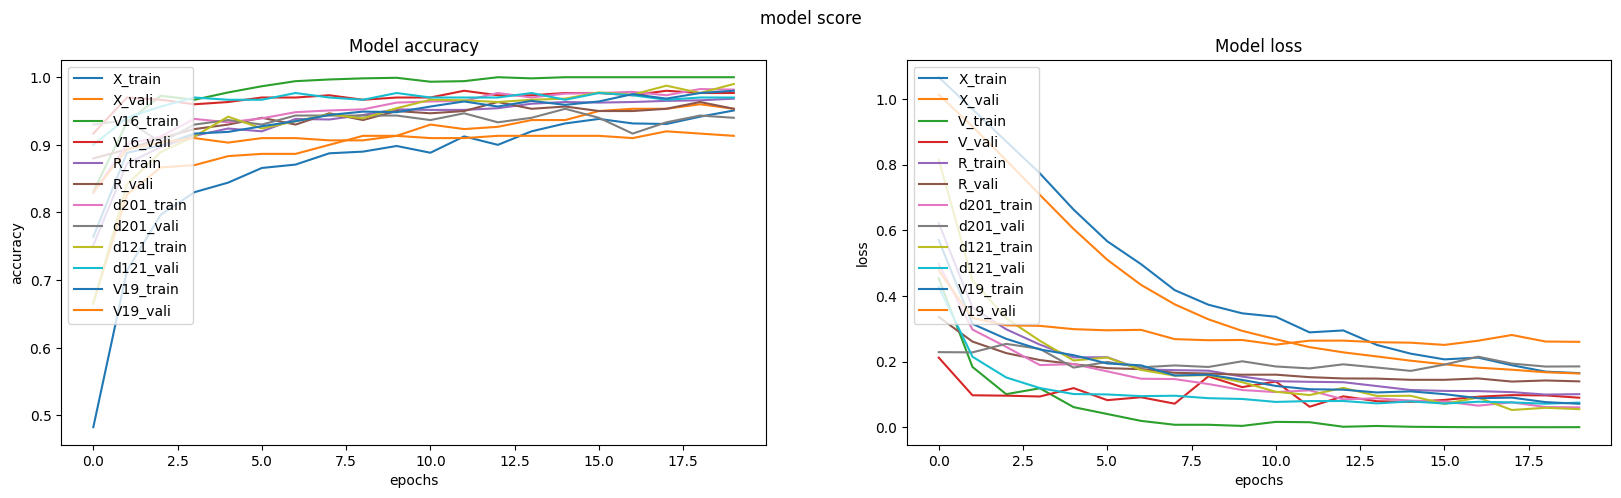

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('model score')

axs[0].plot(history_xception.history["categorical_accuracy"])
axs[0].plot(history_xception.history["val_categorical_accuracy"])
axs[0].plot(history_VGG16.history["categorical_accuracy"])
axs[0].plot(history_VGG16.history["val_categorical_accuracy"])
axs[0].plot(history_rsnt50.history["categorical_accuracy"])
axs[0].plot(history_rsnt50.history["val_categorical_accuracy"])
axs[0].plot(history_dsnt201.history["categorical_accuracy"])
axs[0].plot(history_dsnt201.history["val_categorical_accuracy"])
axs[0].plot(history_DsNt121.history["categorical_accuracy"])
axs[0].plot(history_DsNt121.history["val_categorical_accuracy"])
axs[0].plot(history_VGG19.history["categorical_accuracy"])
axs[0].plot(history_VGG19.history["val_categorical_accuracy"])

axs[0].legend(['X_train', 'X_vali', 'V16_train', 'V16_vali', 'R_train', 'R_vali', 'd201_train', 'd201_vali', 'd121_train', 'd121_vali', 'V19_train', 'V19_vali'], loc='upper left')
axs[0].set_title('Model accuracy')
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")

axs[1].plot(history_xception.history["loss"])
axs[1].plot(history_xception.history["val_loss"])
axs[1].plot(history_VGG16.history["loss"])
axs[1].plot(history_VGG16.history["val_loss"])
axs[1].plot(history_rsnt50.history["loss"])
axs[1].plot(history_rsnt50.history["val_loss"])
axs[1].plot(history_dsnt201.history["loss"])
axs[1].plot(history_dsnt201.history["val_loss"])
axs[1].plot(history_DsNt121.history["loss"])
axs[1].plot(history_DsNt121.history["val_loss"])
axs[1].plot(history_VGG19.history["loss"])
axs[1].plot(history_VGG19.history["val_loss"])
axs[1].legend(['X_train', 'X_vali', 'V_train', 'V_vali', 'R_train', 'R_vali', 'd201_train', 'd201_vali', 'd121_train', 'd121_vali', 'V19_train', 'V19_vali'], loc='upper left')
axs[1].set_title('Model loss')
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("loss")

Text(0, 0.5, 'Loss')

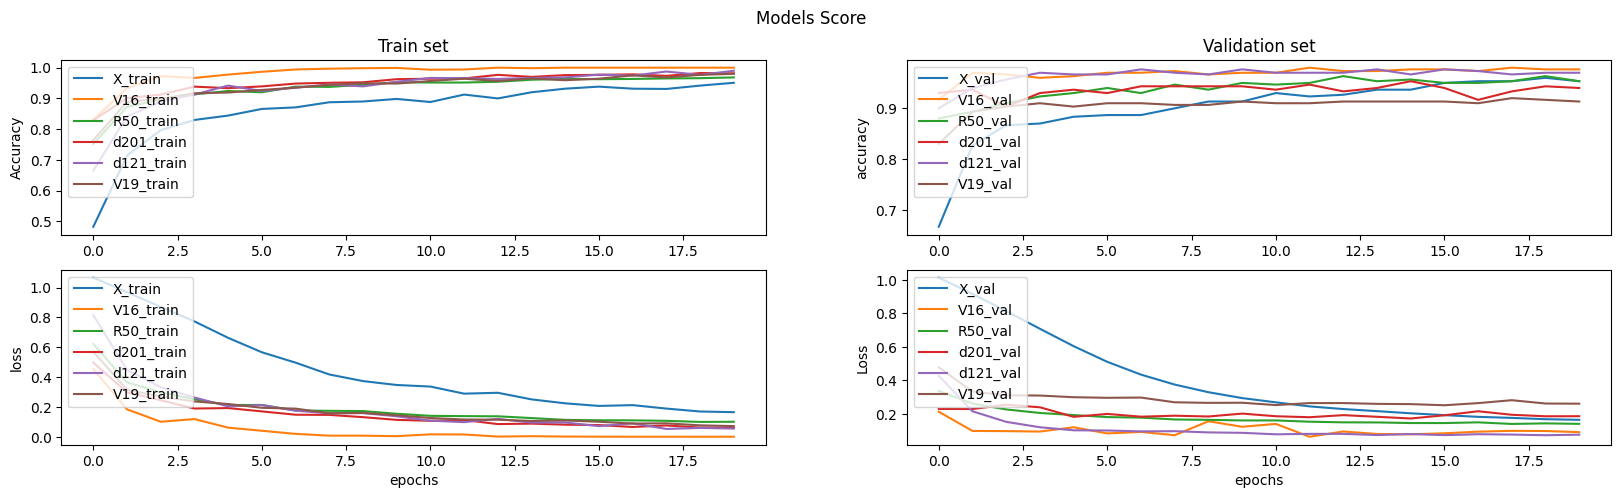

In [ ]:
fig, axs= plt.subplots(nrows=2, ncols=2, figsize=(20,5))
fig.suptitle('Models Score')

axs[0, 0].plot(history_xception.history["categorical_accuracy"])
axs[0, 0].plot(history_VGG16.history["categorical_accuracy"])
axs[0, 0].plot(history_rsnt50.history["categorical_accuracy"])
axs[0, 0].plot(history_dsnt201.history["categorical_accuracy"])
axs[0, 0].plot(history_DsNt121.history["categorical_accuracy"])
axs[0, 0].plot(history_VGG19.history["categorical_accuracy"])
axs[0, 0].legend(['X_train', 'V16_train', 'R50_train', 'd201_train', 'd121_train', 'V19_train'], loc='upper left')
axs[0, 0].set_title( 'Train set')
#axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(history_xception.history["val_categorical_accuracy"])
axs[0, 1].plot(history_VGG16.history["val_categorical_accuracy"])
axs[0, 1].plot(history_rsnt50.history["val_categorical_accuracy"])
axs[0, 1].plot(history_dsnt201.history["val_categorical_accuracy"])
axs[0, 1].plot(history_DsNt121.history["val_categorical_accuracy"])
axs[0, 1].plot(history_VGG19.history["val_categorical_accuracy"])
axs[0, 1].legend(['X_val', 'V16_val', 'R50_val', 'd201_val', 'd121_val', 'V19_val'], loc='upper left')
axs[0, 1].set_title('Validation set')
#axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_ylabel("accuracy")

axs[1, 0].plot(history_xception.history["loss"])
axs[1, 0].plot(history_VGG16.history["loss"])
axs[1, 0].plot(history_rsnt50.history["loss"])
axs[1, 0].plot(history_dsnt201.history["loss"])
axs[1, 0].plot(history_DsNt121.history["loss"])
axs[1, 0].plot(history_VGG19.history["loss"])
axs[1, 0].legend(['X_train', 'V16_train', 'R50_train', 'd201_train', 'd121_train', 'V19_train'], loc='upper left')
#axs[1, 0].set_title('90% Train and 10% Validation')
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")

axs[1, 1].plot(history_xception.history["val_loss"])
axs[1, 1].plot(history_VGG16.history["val_loss"])
axs[1, 1].plot(history_rsnt50.history["val_loss"])
axs[1, 1].plot(history_dsnt201.history["val_loss"])
axs[1, 1].plot(history_DsNt121.history["val_loss"])
axs[1, 1].plot(history_VGG19.history["val_loss"])
axs[1, 1].legend(['X_val', 'V16_val', 'R50_val', 'd201_val', 'd121_val', 'V19_val'], loc='upper left')
#axs[1, 1].set_title('80% Train and 20% Validation')
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_ylabel("Loss")

**Présenter votre meilleure courbe d’entrainement**

Text(0, 0.5, 'loss')

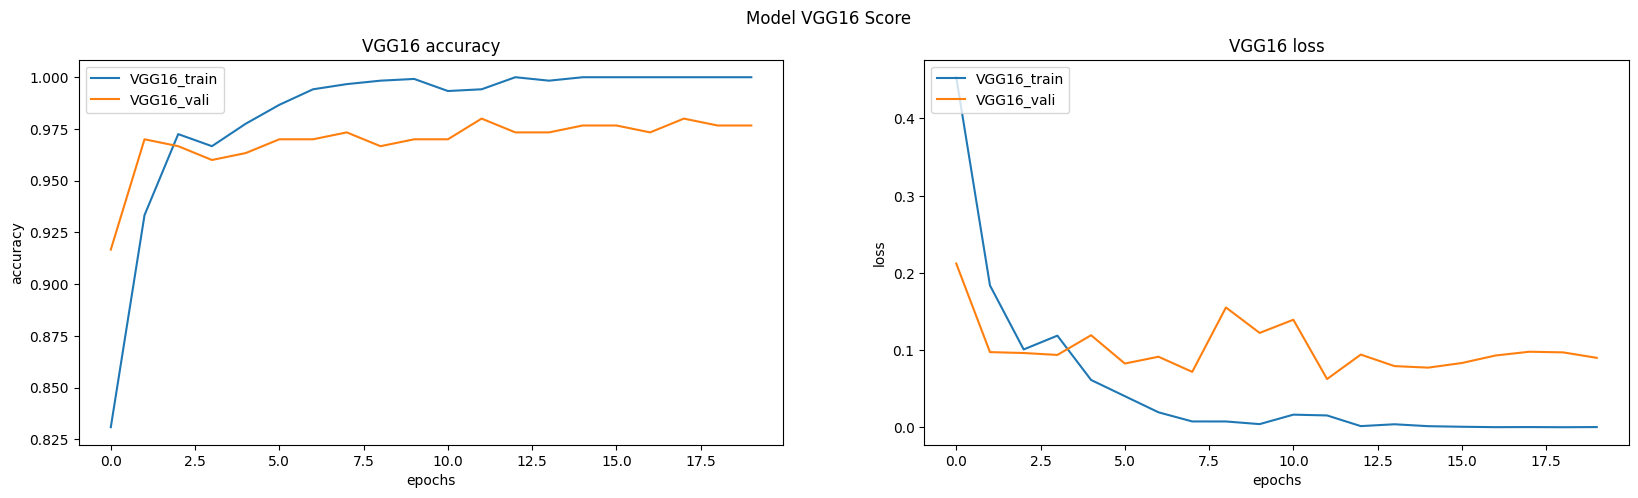

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('Model VGG16 Score')

axs[0].plot(history_VGG16.history["categorical_accuracy"])
axs[0].plot(history_VGG16.history["val_categorical_accuracy"])

axs[0].legend(['VGG16_train', 'VGG16_vali'], loc='upper left')
axs[0].set_title('VGG16 accuracy')
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")

axs[1].plot(history_VGG16.history["loss"])
axs[1].plot(history_VGG16.history["val_loss"])
axs[1].legend(['VGG16_train', 'VGG16_vali'], loc='upper left')
axs[1].set_title('VGG16 loss')
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("loss")

# **15. Créer le jeu de données de test**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset,
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 300 files belonging to 3 classes.


In [ ]:
"""for i in range(len(val_preds)):
  if val_preds[i] == 0:
     val_preds[i] = 'fire'
  elif val_preds[i] == 1:
    val_preds[i] = 'no_fire'
  else:
    val_preds[i] = 'start_fire'
val_preds"""

"for i in range(len(val_preds)):\n  if val_preds[i] == 0:\n     val_preds[i] = 'fire'\n  elif val_preds[i] == 1:\n    val_preds[i] = 'no_fire'\n  else:\n    val_preds[i] = 'start_fire'\nval_preds"

In [ ]:
"""Y_pred = model_DsNt121.predict(test_ds, test_ds)
val_preds = np.argmax(Y_pred, axis=1)
test_ds.class_names"""

'Y_pred = model_DsNt121.predict(test_ds, test_ds)\nval_preds = np.argmax(Y_pred, axis=1)\ntest_ds.class_names'

# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [ ]:
test = model_VGG16.evaluate(test_ds)

38/38 [==============================] - 4s 90ms/step - loss: 0.6555 - categorical_accuracy: 0.8933


In [ ]:
test = model_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 54ms/step - loss: 0.2390 - categorical_accuracy: 0.9067


In [ ]:
test = model_xception.evaluate(test_ds)

38/38 [==============================] - 3s 67ms/step - loss: 0.2900 - categorical_accuracy: 0.8933


In [ ]:
test = model_rsnt50.evaluate(test_ds)

38/38 [==============================] - 3s 59ms/step - loss: 0.3633 - categorical_accuracy: 0.8467


In [ ]:
test = model_VGG19.evaluate(test_ds)

38/38 [==============================] - 5s 119ms/step - loss: 0.3167 - categorical_accuracy: 0.8767


In [ ]:
test = model_dsnt201.evaluate(test_ds)

38/38 [==============================] - 4s 81ms/step - loss: 0.6930 - categorical_accuracy: 0.8267


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

Saving fire.jpg to fire.jpg
Saving no_fire.jpg to no_fire.jpg
Saving start_fire.jpg to start_fire.jpg


{'fire.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x12\x12\x15\x15\x15\x15\x17\x17\x15\x17\x15\x15\x17\x15\x15\x15\x17\x17\x18\x17\x17\x17\x17\x15\x17\x15\x18\x1d( \x18\x1a%\x1d\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a-&\x1f%--------------------------------------------------\xff\xc0\x00\x11\x08\x00\xdc\x00\xe5\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x05\x00\x06\x07\xff\xc4\x00?\x10\x00\x02\x01\x02\x04\x03\x05\x04\x07\x07\x04\x02\x03\x00\x00\x00\x01\x02\x00\x03\x11\x04\x12!1\x05AQ\x13"aq\x81\x062\x91\xa1Rr\xb1\xb2\xc1\xd1\xf0\x07\x14#BC\x82\xa23b\xe1\xf1\x92\xc2\x154c\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\xff\xc4\x002\x11\x00\x02\x02\x01\x03\x02\x04\x05\x04\x02\x02\x03\x01\x00\x00\x00\x00\x01\x02\x11\x03\x

1/1 [==============================] - 1s 1s/step
Class Name : fire --- Class Probability: 100.00%
Class Name : no_fire --- Class Probability: 0.00%
Class Name : start_fire --- Class Probability: 0.00%
----------------------
Class Name : fire --- Class Probability: 98.83%
Class Name : no_fire --- Class Probability: 0.03%
Class Name : start_fire --- Class Probability: 1.13%
----------------------
Class Name : fire --- Class Probability: 98.51%
Class Name : no_fire --- Class Probability: 0.60%
Class Name : start_fire --- Class Probability: 0.88%
----------------------
1/1 [==============================] - 0s 22ms/step
Class Name : fire --- Class Probability: 0.00%
Class Name : no_fire --- Class Probability: 100.00%
Class Name : start_fire --- Class Probability: 0.00%
----------------------
Class Name : fire --- Class Probability: 0.47%
Class Name : no_fire --- Class Probability: 98.42%
Class Name : start_fire --- Class Probability: 1.11%
----------------------
Class Name : fire --- Clas

<Figure size 640x480 with 0 Axes>

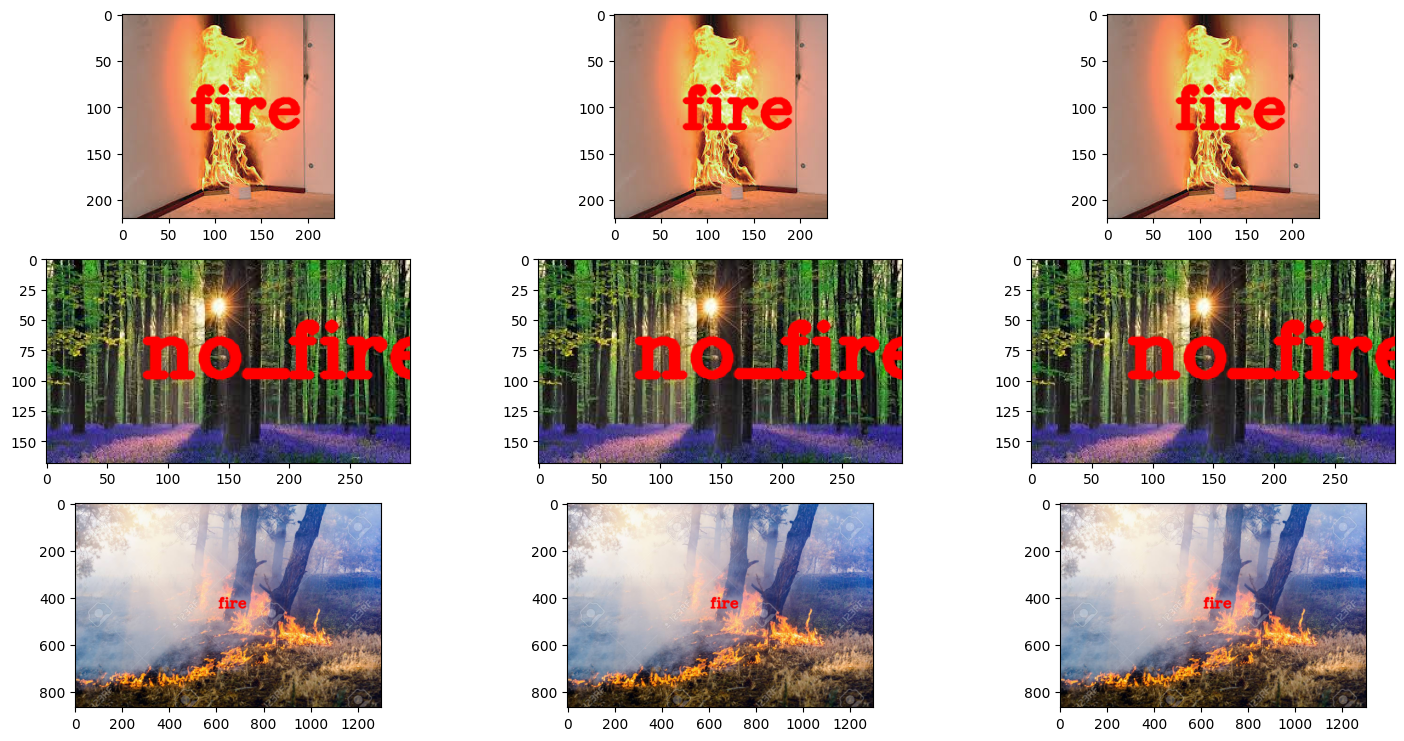

In [ ]:
%matplotlib inline

axes=[]
fig=plt.figure()
fig = plt.figure(figsize=(18,9))

classes = train_ds.class_names
image_path1 =  "fire.jpg"
image_path2 = "no_fire.jpg"
image_path3 = "start_fire.jpg"
liste_image = [image_path1, image_path2, image_path3]

compteur = 1
for image_path in liste_image:
    # predict Xception.
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(299,299))
    x = np.expand_dims(x, axis=0)
    pred1 = model_VGG16.predict(x,batch_size=1)[0]

    # predict VGG16 et VGG19.
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(299,299))
    x = np.expand_dims(x, axis=0)
    pred2 = model_DsNt121.predict(x,batch_size=1)[0]
    pred3 = model_xception.predict(x,batch_size=1)[0]

    liste = [pred1, pred2, pred3]
    for pred in liste:
        for (pos,prob) in enumerate(pred):
            class_name = classes[pos]
            if (pos == np.argmax(pred)) :
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                font = cv2.FONT_HERSHEY_COMPLEX
                textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
                textX = (img.shape[1] - textsize[0]) / 2
                textY = (img.shape[0] + textsize[1]) / 2
                cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
                axes.append(fig.add_subplot(3, 3, compteur))
                plt.imshow(img)
                compteur += 1
            #print("Top %d ====================" % (i + 1))
            print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
        print("----------------------")

plt.show()

**Décrire l’influence du taux division des données (train/validation/test) sur le résultat de classification**

In [ ]:
# créer les jeux de données d'ntrainement 90%
train_ds_0 = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.1,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)

# données de validation 10%
val_ds_0 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

# créer les jeux de données d'ntrainement 80%
train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)

# données de validation 20%
val_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

# créer les jeux de données d'ntrainement 50%
train_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.5,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)

# données de validation 50%
val_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.5,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

# créer les jeux de données d'ntrainement 20%
train_ds_3 = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.8,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)

# données de validation 80%
val_ds_3 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.8,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 1500 files belonging to 3 classes.
Using 1350 files for training.
Found 1500 files belonging to 3 classes.
Using 150 files for validation.
Found 1500 files belonging to 3 classes.
Using 1200 files for training.
Found 1500 files belonging to 3 classes.
Using 300 files for validation.
Found 1500 files belonging to 3 classes.
Using 750 files for training.
Found 1500 files belonging to 3 classes.
Using 750 files for validation.
Found 1500 files belonging to 3 classes.
Using 300 files for training.
Found 1500 files belonging to 3 classes.
Using 1200 files for validation.


In [ ]:
# DenseNet121 model
DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))
# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model0_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)

DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))
# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model1_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)

DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))
# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model2_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)

DsNt121 = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(299, 299,3))
# create a custom top classifier
x = DsNt121.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model3_DsNt121 = Model(inputs = DsNt121.inputs, outputs=predictions)



In [ ]:
   # compiler le modèle
model0_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model1_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model2_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model3_DsNt121.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
# entrainer le modèle
history_0 = model0_DsNt121.fit(
    train_ds_0,
    epochs=epochs,
    validation_data=val_ds_0
)

Epoch 1/20
169/169 [==============================] - 70s 225ms/step - loss: 0.7454 - categorical_accuracy: 0.7089 - val_loss: 0.3793 - val_categorical_accuracy: 0.9000
Epoch 2/20
169/169 [==============================] - 34s 198ms/step - loss: 0.4247 - categorical_accuracy: 0.8563 - val_loss: 0.2000 - val_categorical_accuracy: 0.9667
Epoch 3/20
169/169 [==============================] - 35s 207ms/step - loss: 0.2901 - categorical_accuracy: 0.9081 - val_loss: 0.1371 - val_categorical_accuracy: 0.9733
Epoch 4/20
169/169 [==============================] - 34s 201ms/step - loss: 0.2390 - categorical_accuracy: 0.9215 - val_loss: 0.1208 - val_categorical_accuracy: 0.9667
Epoch 5/20
169/169 [==============================] - 35s 207ms/step - loss: 0.1980 - categorical_accuracy: 0.9304 - val_loss: 0.0803 - val_categorical_accuracy: 0.9800
Epoch 6/20
169/169 [==============================] - 34s 200ms/step - loss: 0.1829 - categorical_accuracy: 0.9400 - val_loss: 0.0690 - val_categorical_acc

In [ ]:
# entrainer le modèle
history_1 = model1_DsNt121.fit(
    train_ds_1,
    epochs=epochs,
    validation_data=val_ds_1
)

Epoch 1/20
150/150 [==============================] - 68s 230ms/step - loss: 0.8121 - categorical_accuracy: 0.6567 - val_loss: 0.4782 - val_categorical_accuracy: 0.9000
Epoch 2/20
150/150 [==============================] - 34s 225ms/step - loss: 0.4708 - categorical_accuracy: 0.8400 - val_loss: 0.2512 - val_categorical_accuracy: 0.9467
Epoch 3/20
150/150 [==============================] - 34s 224ms/step - loss: 0.3210 - categorical_accuracy: 0.8967 - val_loss: 0.1747 - val_categorical_accuracy: 0.9567
Epoch 4/20
150/150 [==============================] - 33s 216ms/step - loss: 0.2468 - categorical_accuracy: 0.9242 - val_loss: 0.1271 - val_categorical_accuracy: 0.9600
Epoch 5/20
150/150 [==============================] - 33s 219ms/step - loss: 0.2108 - categorical_accuracy: 0.9325 - val_loss: 0.1069 - val_categorical_accuracy: 0.9633
Epoch 6/20
150/150 [==============================] - 33s 218ms/step - loss: 0.1994 - categorical_accuracy: 0.9367 - val_loss: 0.1019 - val_categorical_acc

In [ ]:
history_2 = model2_DsNt121.fit(
    train_ds_2,
    epochs=epochs,
    validation_data=val_ds_2
)

Epoch 1/20
94/94 [==============================] - 62s 314ms/step - loss: 0.9263 - categorical_accuracy: 0.5773 - val_loss: 0.6785 - val_categorical_accuracy: 0.8373
Epoch 2/20
94/94 [==============================] - 27s 290ms/step - loss: 0.6048 - categorical_accuracy: 0.8093 - val_loss: 0.4383 - val_categorical_accuracy: 0.8920
Epoch 3/20
94/94 [==============================] - 27s 287ms/step - loss: 0.4308 - categorical_accuracy: 0.8627 - val_loss: 0.3071 - val_categorical_accuracy: 0.9053
Epoch 4/20
94/94 [==============================] - 27s 287ms/step - loss: 0.3261 - categorical_accuracy: 0.8973 - val_loss: 0.2372 - val_categorical_accuracy: 0.9240
Epoch 5/20
94/94 [==============================] - 27s 289ms/step - loss: 0.2731 - categorical_accuracy: 0.9200 - val_loss: 0.2051 - val_categorical_accuracy: 0.9280
Epoch 6/20
94/94 [==============================] - 28s 293ms/step - loss: 0.2679 - categorical_accuracy: 0.9107 - val_loss: 0.1765 - val_categorical_accuracy: 0.949

In [ ]:
history_3 = model3_DsNt121.fit(
    train_ds_3,
    epochs=epochs,
    validation_data=val_ds_3
)

Epoch 1/20
38/38 [==============================] - 62s 665ms/step - loss: 1.0002 - categorical_accuracy: 0.5167 - val_loss: 0.9650 - val_categorical_accuracy: 0.5075
Epoch 2/20
38/38 [==============================] - 21s 548ms/step - loss: 0.7874 - categorical_accuracy: 0.7200 - val_loss: 0.7393 - val_categorical_accuracy: 0.7775
Epoch 3/20
38/38 [==============================] - 28s 744ms/step - loss: 0.6646 - categorical_accuracy: 0.7733 - val_loss: 0.5542 - val_categorical_accuracy: 0.8867
Epoch 4/20
38/38 [==============================] - 21s 562ms/step - loss: 0.5305 - categorical_accuracy: 0.8467 - val_loss: 0.4683 - val_categorical_accuracy: 0.8800
Epoch 5/20
38/38 [==============================] - 21s 552ms/step - loss: 0.4444 - categorical_accuracy: 0.8767 - val_loss: 0.4130 - val_categorical_accuracy: 0.8800
Epoch 6/20
38/38 [==============================] - 21s 560ms/step - loss: 0.4062 - categorical_accuracy: 0.8900 - val_loss: 0.3500 - val_categorical_accuracy: 0.898

Text(0.5, 0, 'epochs')

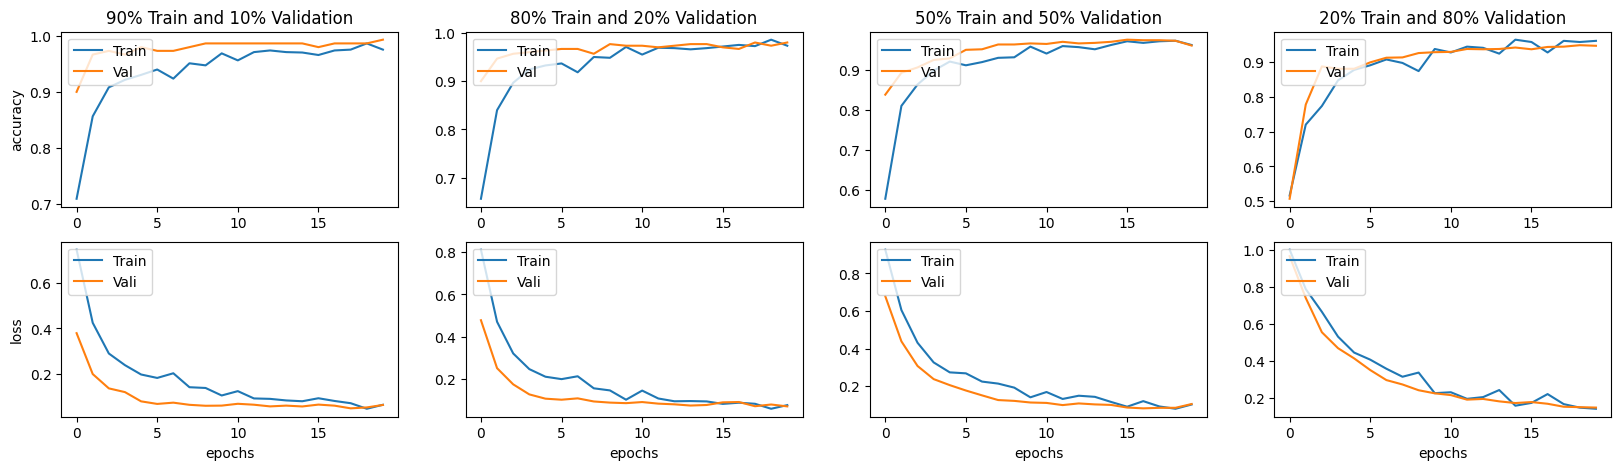

In [ ]:
fig, axs= plt.subplots(nrows=2, ncols=4, figsize=(20,5))
#fig.suptitle('Rates')

axs[0, 0].plot(history_0.history["categorical_accuracy"])
axs[0, 0].plot(history_0.history["val_categorical_accuracy"])
axs[0, 0].legend(['Train', 'Val'], loc='upper left')
axs[0, 0].set_title('90% Train and 10% Validation')
#axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("accuracy")

axs[1, 0].plot(history_0.history["loss"])
axs[1, 0].plot(history_0.history["val_loss"])
axs[1, 0].legend(['Train', 'Vali'], loc='upper left')
#axs[1, 0].set_title('90% Train and 10% Validation')
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")

axs[0, 1].plot(history_1.history["categorical_accuracy"])
axs[0, 1].plot(history_1.history["val_categorical_accuracy"])
axs[0, 1].legend(['Train', 'Val'], loc='upper left')
axs[0, 1].set_title('80% Train and 20% Validation')
#axs[0, 1].set_xlabel("epochs")
#axs[0, 1].set_ylabel("accuracy")

axs[1, 1].plot(history_1.history["loss"])
axs[1, 1].plot(history_1.history["val_loss"])
axs[1, 1].legend(['Train', 'Vali'], loc='upper left')
#axs[1, 1].set_title('80% Train and 20% Validation')
axs[1, 1].set_xlabel("epochs")
#axs[1, 1].set_ylabel("loss")

axs[0, 2].plot(history_2.history["categorical_accuracy"])
axs[0, 2].plot(history_2.history["val_categorical_accuracy"])
axs[0, 2].legend(['Train', 'Val'], loc='upper left')
axs[0, 2].set_title('50% Train and 50% Validation')
#axs[0, 2].set_xlabel("epochs")
#axs[0, 2].set_ylabel("accuracy")

axs[1, 2].plot(history_2.history["loss"])
axs[1, 2].plot(history_2.history["val_loss"])
axs[1, 2].legend(['Train', 'Vali'], loc='upper left')
#axs[1, 2].set_title('50% Train and 50% Validation')
axs[1, 2].set_xlabel("epochs")
#axs[1, 2].set_ylabel("loss")

axs[0, 3].plot(history_3.history["categorical_accuracy"])
axs[0, 3].plot(history_3.history["val_categorical_accuracy"])
axs[0, 3].legend(['Train', 'Val'], loc='upper left')
axs[0, 3].set_title('20% Train and 80% Validation')
#axs[0, 3].set_xlabel("epochs")
#axs[0, 3].set_ylabel("accuracy")

axs[1, 3].plot(history_3.history["loss"])
axs[1, 3].plot(history_3.history["val_loss"])
axs[1, 3].legend(['Train', 'Vali'], loc='upper left')
#axs[1, 3].set_title('20% Train and 80% Validation')
axs[1, 3].set_xlabel("epochs")
#axs[1, 3].set_ylabel("loss")

In [ ]:
# Evaluation des modèles sur le test
test_0 = model0_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 56ms/step - loss: 0.2942 - categorical_accuracy: 0.8967


In [ ]:
test_1 = model1_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 57ms/step - loss: 0.2581 - categorical_accuracy: 0.9033


In [ ]:
test_2 = model2_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 57ms/step - loss: 0.3611 - categorical_accuracy: 0.8867


In [ ]:
test_3 = model3_DsNt121.evaluate(test_ds)

38/38 [==============================] - 3s 55ms/step - loss: 0.3271 - categorical_accuracy: 0.8500


In [ ]:
model0_DsNt121.save("model0_DsNt121.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model1_DsNt121.save("model1_DsNt121.h5")

In [ ]:
model2_DsNt121.save("model2_DsNt121.h5")

In [ ]:
model3_DsNt121.save("model3_DsNt121.h5")